# Welcome to ApplyAI 3
During this workshop you and Madhu will build an image classifier capable of recognizing beer images!

**First Step** Click "Open in playground" in the top left corner, CTRL + S to save and then "SAVE A COPY IN DRIVE"

**Second Step** Execute the following block of uninportant code and follow the instructions to download the dataset

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import time
import numpy as np
import matplotlib.pyplot as plt
import cv2

from mpl_toolkits.axes_grid1 import ImageGrid

def download_dataset():
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth).CreateFile({'id': "15iuC4k4OfJxJZ2zOfn7qheuCBwV0Yvtl"}).GetContentFile('beer_not_beer_40k.npz')

def read_dataset(name="beer_not_beer_40k.npz", channel_first=True, required_size=None):
  X, y = [np.load(name)[x] for x in ("X", "y")]
  print("Loaded X has shape (image_id, channel, height, width) =", X.shape)
  print("Loaded y has shape (image_id) =", y.shape)

  # converts from (n, layer, x, y) to (n, x, y, layer) for better interoperability with keras
  # nb: Conv layers works with "layer last" input too, but it's rarely used and apparently doesn't work with 2.0.0.rc0 framework
  if channel_first:
    X = np.rollaxis(X, 1, 4)

  if required_size != None:
    # resize images to required_size
    resized_images = []
    for i in range(X.shape[0]):
      resized = cv2.resize(X[i], dsize=(required_size, required_size), interpolation=cv2.INTER_CUBIC)
      resized_images.append(resized)

    X = np.stack(resized_images, axis=0)
    
    print("X has been resized to shape (image_id, height, width, channel) =", X.shape)
  
  return X, y

def show_first_images(X):
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

    for ax, x in zip(grid, X):
        ax.imshow(x.transpose(1, 2, 0))

download_dataset()

The dataset is composed of 40'000 images: 20'000 beer images (they can be bottles, cans or full glasses) and 20'000 random images taken from a public dataset (there surely are no glasses, bottles or cans among them).

All images have size 64x64 and are stored in the variable "X", the corresponing lables are stored in "y" (1 = beer, 0 = not beer)



In [26]:
X, y = read_dataset(required_size=71)

Loaded X has shape (image_id, channel, height, width) = (40000, 3, 64, 64)
Loaded y has shape (image_id) = (40000,)
X has been resized to shape (image_id, height, width, channel) = (40000, 71, 71, 3)


## Visualize 25 images for each class 

Beers (y=1)


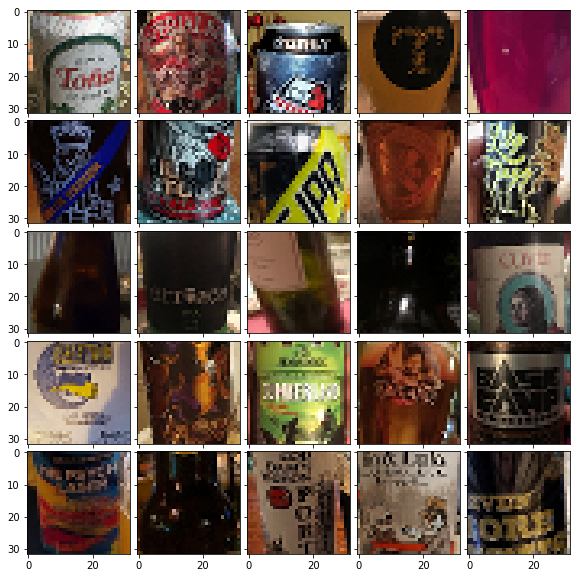

In [19]:
print('Beers (y=1)')
show_first_images(np.rollaxis(X[np.where(y == 1)][:25], 3, 1))

Other stuff (y=0)


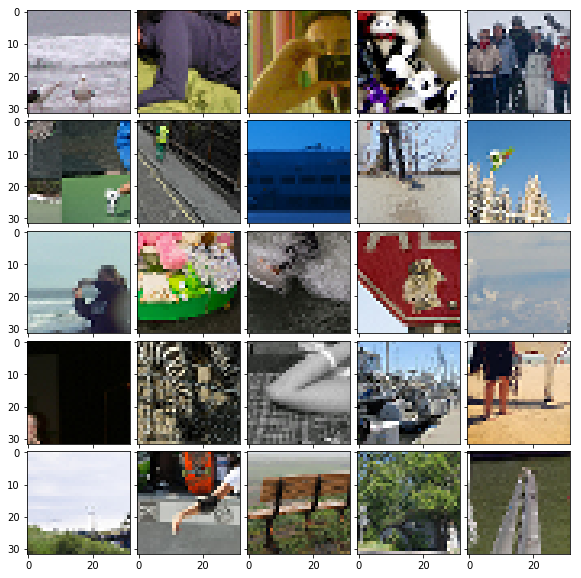

In [20]:
print('Other stuff (y=0)')
show_first_images(np.rollaxis(X[np.where(y == 0)][:25], 3, 1))

# Install TF2.X

In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [22]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0rc3:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0rc3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0rc3


In [23]:
!pip install tensorflow

     |████████████████████████████████| 86.3MB 34.1MB/s 
     |████████████████████████████████| 3.8MB 36.0MB/s 
     |████████████████████████████████| 450kB 47.5MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


## Visualize data

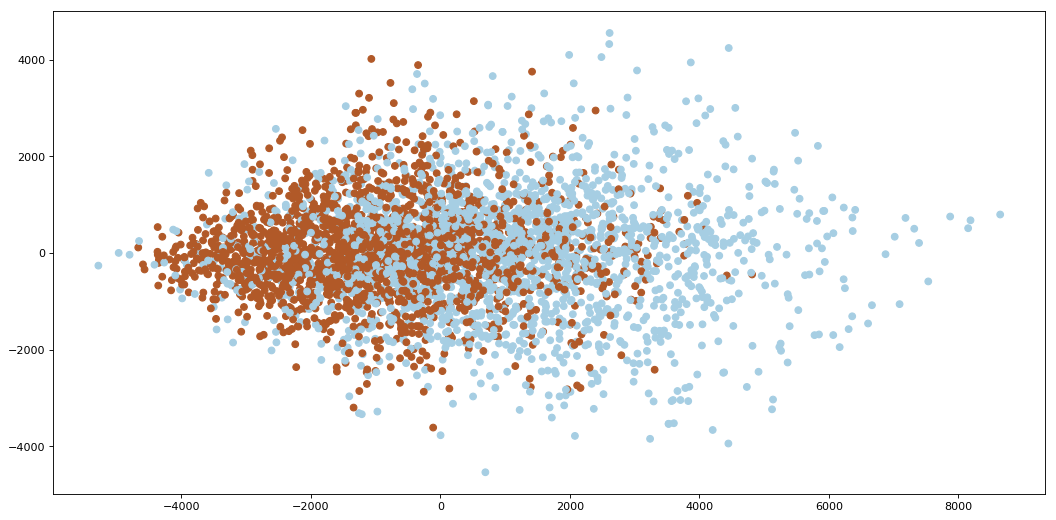

CPU times: user 2.19 s, sys: 995 ms, total: 3.19 s
Wall time: 1.18 s


In [15]:
%%time
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver='auto')

X_limit = 4000 # PCA it's heavy for 40K images but it can easily deal with 4K
X_pca = pca.fit_transform(X[:X_limit].reshape(X_limit, 32*32*3))

f = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y[:X_limit], cmap="Paired")
plt.show()

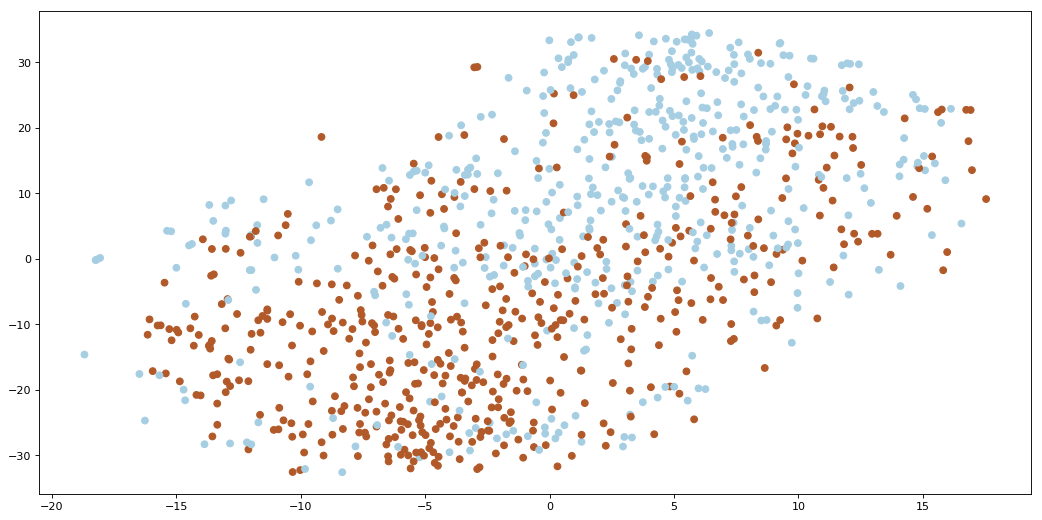

In [18]:
%%time
from sklearn.manifold import TSNE

X_limit = 1000 # it can't work with 40K images but it can deal with 1K in a reasonable amount of time
X_tsne = TSNE(n_components=2, perplexity=20, learning_rate=100).fit_transform(X[:X_limit].reshape(X_limit, 32*32*3))

f = plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y[:X_limit], cmap="Paired")
plt.show()

### Let's save 10% of data for validation 

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X / 255, y, shuffle=False, test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36000, 71, 71, 3) (4000, 71, 71, 3) (36000,) (4000,)


In [8]:
from tensorflow.keras.layers import * # let's import * to make it quick ;)
from tensorflow.keras.models import Sequential


# Vanilla CNN with 3x3 filters, doubling kernels each time, maxpooling and batch normalization as standard
# finally 2 fully connected layers with drastic dropout (50%) to overcome overfitting
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 6, 64)          256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 128)        

In [0]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.003)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(X_train, y_train, epochs=10, shuffle=True, validation_data = (X_test, y_test), batch_size=1_000)

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 31s 863us/sample - loss: 0.1767 - accuracy: 0.9316 - val_loss: 2.2291 - val_accuracy: 0.4840
Epoch 2/10
36000/36000 [==============================] - 31s 853us/sample - loss: 0.1649 - accuracy: 0.9363 - val_loss: 3.0131 - val_accuracy: 0.4840
Epoch 3/10
36000/36000 [==============================] - 31s 852us/sample - loss: 0.1520 - accuracy: 0.9413 - val_loss: 2.2428 - val_accuracy: 0.4890
Epoch 4/10
36000/36000 [==============================] - 31s 856us/sample - loss: 0.1379 - accuracy: 0.9477 - val_loss: 2.8342 - val_accuracy: 0.4893
Epoch 5/10
36000/36000 [==============================] - 31s 855us/sample - loss: 0.1329 - accuracy: 0.9493 - val_loss: 2.4496 - val_accuracy: 0.4988
Epoch 6/10
36000/36000 [==============================] - 31s 856us/sample - loss: 0.1263 - accuracy: 0.9506 - val_loss: 1.8839 - val_accuracy: 0.5380
Epoch 7/10
36000/36000 [=====================

In [16]:
from sklearn.model_selection import StratifiedKFold

k = 5
fold_epochs = 5
batch_size = 4_000

folds = list(StratifiedKFold(n_splits=k, shuffle=True, random_state=1).split(X_train, y_train))
for j, (idx_train, idx_valid) in enumerate(folds):
    
    print('\nFold ', (j+1))
    X_fold_train = X_train[idx_train]
    y_fold_train = y_train[idx_train]
    X_fold_valid = X_train[idx_valid]
    y_fold_valid= y_train[idx_valid]

    history = model.fit(X_fold_train, y_fold_train,
              epochs=fold_epochs,
              shuffle=True,
              validation_data = (X_fold_valid, y_fold_valid),
              batch_size=batch_size)

    print(model.evaluate(X_test, y_test))


Fold  1
Train on 28800 samples, validate on 7200 samples
Epoch 1/5
28800/28800 [==============================] - 27s 922us/sample - loss: 0.0794 - accuracy: 0.9686 - val_loss: 0.2739 - val_accuracy: 0.8979
Epoch 2/5
28800/28800 [==============================] - 26s 915us/sample - loss: 0.0724 - accuracy: 0.9726 - val_loss: 0.2525 - val_accuracy: 0.9097
Epoch 3/5
28800/28800 [==============================] - 26s 916us/sample - loss: 0.0707 - accuracy: 0.9729 - val_loss: 0.1749 - val_accuracy: 0.9362
Epoch 4/5
28800/28800 [==============================] - 26s 915us/sample - loss: 0.0609 - accuracy: 0.9770 - val_loss: 0.3481 - val_accuracy: 0.8864
Epoch 5/5
28800/28800 [==============================] - 26s 914us/sample - loss: 0.0609 - accuracy: 0.9757 - val_loss: 0.1232 - val_accuracy: 0.9531
4000/1 [========================================================================================================================================================================================

In [17]:
model.evaluate(X_test, y_test)

4000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.29084891896229237, 0.9335]

**0.93x** isn't bad but it can most likely with further training and better tuning 

In [0]:
from sklearn import metrics


y_hat = model.predict(X_test)
y_hat = np.argmax(predictions, axis=1)

print("Accuracy: {}%".format(100*final_acc))
print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, y_hat, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, y_hat, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, y_hat, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, y_hat)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)

# Use pre-trained model (Xception)

https://arxiv.org/abs/1610.02357

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception

xception_model = Xception(input_shape=(71, 71, 3), include_top=False, pooling='max')
for layer in xception_model.layers:
  layer.trainable = False
  
# retrieve output layer to attach our custom layers
output = xception_model.layers[-1].output

# attach standard 2 layer with some random dropout
# output = Flatten()(output)
output = Dropout(0.33)(output)
output = Dense(128, activation='relu', name='custom_fully_connected')(output)
output = Dropout(0.33)(output)
output = Dense(1, activation='sigmoid', name='custom_output')(output)

# compile with Xception input and our output
model = Model(xception_model.input, output)
model.summary()

opt = Adam(lr=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 35, 35, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 35, 35, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 35, 35, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [56]:
%%time
X_pretrained_activations = xception_model.predict(X)

CPU times: user 44min 58s, sys: 1min 42s, total: 46min 40s
Wall time: 12min 13s


In [65]:
custom_model_input = Input(shape=(2048,))
# custom_model = Dropout(0.33)(custom_model_input)
custom_model = Dense(128, activation='relu', name='custom_fully_connected')(custom_model_input)
custom_model = Dropout(0.2)(custom_model)
custom_model = Dense(1, activation='sigmoid', name='custom_output')(custom_model)

# compile with Xception input and our output
custom_model = Model(custom_model_input, custom_model)
custom_model.summary()

custom_model.compile(optimizer=Adam(lr=0.003), loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X_pretrained_activations, y, shuffle=True, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

custom_model.fit(X_train, y_train, epochs=100, shuffle=True, validation_data = (X_test, y_test), batch_size=4_000)

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 2048)]            0         
_________________________________________________________________
custom_fully_connected (Dens (None, 128)               262272    
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
custom_output (Dense)        (None, 1)                 129       
Total params: 262,401
Trainable params: 262,401
Non-trainable params: 0
_________________________________________________________________
(32000, 2048) (8000, 2048) (32000,) (8000,)
Train on 32000 samples, validate on 8000 samples
Epoch 1/100
32000/32000 [==============================] - 1s 36us/sample - loss: 47.0906 - accuracy: 0.5584 - val_loss: 29.0296 - val_accuracy: 0.5968
Epoch

## Results of pre-trained model

The model is trained using only the ativations to speed-up the testing, it converges in 100 epochs giving poor results.
I thought to assemble the actual model using these weights and the full Xception model ma given the performance I can't be bothered of doing it.